In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchlibrosa.stft import Spectrogram, LogmelFilterBank
from torchlibrosa.augmentation import SpecAugmentation
import librosa
import numpy as np
import matplotlib.pyplot as plt
import cv2


def init_layer(layer):
    """Initialize a Linear or Convolutional layer. """
    nn.init.xavier_uniform_(layer.weight)
 
    if hasattr(layer, 'bias'):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)
            
    
def init_bn(bn):
    """Initialize a Batchnorm layer. """
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        
        super(ConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.conv2 = nn.Conv2d(in_channels=out_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.init_weight()
        
    def init_weight(self):
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)

        
    def forward(self, input, pool_size=(2, 2), pool_type='avg'):
        
        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')
        
        return x



class Cnn10(nn.Module):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin, 
        fmax, classes_num):
        
        super(Cnn10, self).__init__()

        window = 'hann'
        center = True
        pad_mode = 'reflect'
        ref = 1.0
        amin = 1e-10
        top_db = None
        
        self.spectrogram = None
        self.conv_output = None
        self.gradients = None

        # Spectrogram extractor
        self.spectrogram_extractor = Spectrogram(n_fft=window_size, hop_length=hop_size, 
            win_length=window_size, window=window, center=center, pad_mode=pad_mode, 
            freeze_parameters=True)

        # Logmel feature extractor
        self.logmel_extractor = LogmelFilterBank(sr=sample_rate, n_fft=window_size, 
            n_mels=mel_bins, fmin=fmin, fmax=fmax, ref=ref, amin=amin, top_db=top_db, 
            freeze_parameters=True)

        # Spec augmenter
        self.spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=2, 
            freq_drop_width=8, freq_stripes_num=2)

        self.bn0 = nn.BatchNorm2d(64)

        self.conv_block1 = ConvBlock(in_channels=1, out_channels=64)
        self.conv_block2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv_block3 = ConvBlock(in_channels=128, out_channels=256)
        self.conv_block4 = ConvBlock(in_channels=256, out_channels=512)

        self.fc1 = nn.Linear(512, 512, bias=True)
        self.fc_audioset = nn.Linear(512, classes_num, bias=True)
        
        self.init_weight()

    def init_weight(self):
        init_bn(self.bn0)
        init_layer(self.fc1)
        init_layer(self.fc_audioset)
        
    def save_gradients(self, grad):
        self.gradients = grad
 
    def forward(self, input, mixup_lambda=None):
        """
        Input: (batch_size, data_length)"""

        x = self.spectrogram_extractor(input)   # (batch_size, 1, time_steps, freq_bins)
        x = self.logmel_extractor(x)    # (batch_size, 1, time_steps, mel_bins)
        # get spectrogram
        self.spectrogram = x
        
        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        
        if self.training:
            x = self.spec_augmenter(x)

        # Mixup on spectrogram
        if self.training and mixup_lambda is not None:
            x = do_mixup(x, mixup_lambda)
        
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg')
        # register hook
        x.register_hook(self.save_gradients)
        
        x = F.dropout(x, p=0.2, training=self.training)
        self.conv_output = x
        
        x = torch.mean(x, dim=3)
        
        (x1, _) = torch.max(x, dim=2)
        x2 = torch.mean(x, dim=2)
        x = x1 + x2
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu_(self.fc1(x))
        embedding = F.dropout(x, p=0.5, training=self.training)
        clipwise_output = torch.sigmoid(self.fc_audioset(x))
        
        output_dict = {'clipwise_output': clipwise_output, 'embedding': embedding}

        return output_dict

    
class Transfer_Cnn10(nn.Module):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin,
                 fmax, classes_num, freeze_base_num):
        """Classifier for a new task using pretrained Cnn14 as a sub module.
        """
        super(Transfer_Cnn10, self).__init__()
        audioset_classes_num = 527

        self.base = Cnn10(sample_rate, window_size, hop_size, mel_bins,
                          fmin, fmax, audioset_classes_num)

        # Transfer to another task layer
        self.fc_transfer = nn.Linear(512, classes_num, bias=True)

        # Freeze AudioSet pretrained layers
        count = 0
        for child in self.base.children():
            if count < freeze_base_num: 
                for param in child.parameters():
                    param.requires_grad = False
                    count += 1

        self.init_weights()       

    def init_weights(self):
        init_layer(self.fc_transfer)

    def load_from_pretrain(self, pretrained_checkpoint_path):
        checkpoint = torch.load(pretrained_checkpoint_path)
        self.base.load_state_dict(checkpoint['model'])
        
    def forward(self, input, mixup_lambda=None):
        """Input: (batch_size, data_length)
        """
        output_dict = self.base(input, mixup_lambda)
        embedding = output_dict['embedding']

        #         clipwise_output = torch.log_softmax(self.fc_transfer(embedding), dim=-1)
        clipwise_output = torch.sigmoid(self.fc_transfer(embedding))
        output_dict['clipwise_output'] = clipwise_output

        return output_dict

    
BIRD_CODE = {  # filtered by Dropping_Threshold = 10
    'Oecanthus': 0, 'Bubo': 1, 'Garrulus': 2, 'Bucephala': 3, 'Gallinago': 4, 'Oriolus': 5, 
    'Columba': 6, 'Perdix': 7, 'Anas': 8, 'Amazona': 9, 'Passer': 10, 'Aegolius': 11, 
    'Streptopelia': 12, 'Sturnus': 13, 'Motacilla': 14, 'Panurus': 15, 'Phalacrocorax': 16, 
    'Coloeus': 17, 'Chlidonias': 18, 'Apus': 19, 'Actitis': 20, 'Rallus': 21, 'Branta': 22, 
    'Recurvirostra': 23, 'Nycticorax': 24, 'Falco': 25, 'Jynx': 26, 'Carduelis': 27, 'Haliaeetus': 28, 
    'Dendrocopos': 29, 'Buteo': 30, 'Ficedula': 31, 'Emberiza': 32, 'Corvus': 33, 'Regulus': 34, 
    'Pluvialis': 35, 'Sylvia': 36, 'Aegithalos': 37, 'Dryocopus': 38, 'Carpodacus': 39, 
    'Botaurus': 40, 'Phoenicurus': 41, 'Muscicapa': 42, 'Troglodytes': 43, 'Coturnix': 44, 
    'Otus': 45, 'Saxicola': 46, 'Mergus': 47, 'Ixobrychus': 48, 'Tadorna': 49, 'Psittacula': 50, 
    'Remiz': 51, 'Charadrius': 52, 'Larus': 53, 'Poecile': 54, 'Haematopus': 55, 'Cyanistes': 56, 
    'Crex': 57, 'Glaucidium': 58, 'Acrocephalus': 59, 'Coccothraustes': 60, 'Fulica': 61, 'Linaria': 62, 
    'Luscinia': 63, 'Hippolais': 64, 'Sitta': 65, 'Porzana': 66, 'Anthus': 67, 'Upupa': 68, 'Spatula': 69, 
    'Phylloscopus': 70, 'Strix': 71, 'Mareca': 72, 'Picus': 73, 'Riparia': 74, 'Dryobates': 75, 
    'Sonus': 76, 'Tyto': 77, 'Chloris': 78, 'Lullula': 79, 'Podiceps': 80, 'Ardea': 81, 'Circus': 82, 
    'Hirundo': 83, 'Pica': 84, 'Alopochen': 85, 'Chroicocephalus': 86, 'Numenius': 87, 'Accipiter': 88, 
    'Alcedo': 89, 'Grus': 90, 'Athene': 91, 'Aythya': 92, 'Caprimulgus': 93, 'Locustella': 94, 
    'Gallinula': 95, 'Lophophanes': 96, 'Delichon': 97, 'Phasianus': 98, 'Acanthis': 99, 'Parus': 100, 
    'Anser': 101, 'Scolopax': 102, 'Turdus': 103, 'Limosa': 104, 'Spinus': 105, 'Serinus': 106, 
    'Prunella': 107, 'Periparus': 108, 'Certhia': 109, 'Loxia': 110, 'Bombycilla': 111, 'Sterna': 112, 
    'Asio': 113, 'Merops': 114, 'Pyrrhula': 115, 'Lanius': 116, 'Fringilla': 117, 'Erithacus': 118, 
    'Aix': 119, 'Cuculus': 120, 'Calidris': 121, 'Tringa': 122, 'Tachybaptus': 123, 'Cinclus': 124, 
    'Dendrocoptes': 125, 'Milvus': 126, 'Vanellus': 127, 'Cygnus': 128, 'Alauda': 129
}
INV_BIRD_CODE = {v: k for k, v in BIRD_CODE.items()}

In [2]:
# load pretrained model parameters
sample_rate = 32000
window_size = 1024
hop_size = 320
mel_bins = 64
fmin = 50
fmax = 14000
classes_num = 130
model = Transfer_Cnn10(sample_rate, window_size, hop_size, mel_bins, fmin, fmax, classes_num, 0)
# parallel
model = torch.nn.DataParallel(model)


# filename = "best_Transfer_Cnn10nonemixupfreeze0_mAP=0.707.pth"
filename = "best_Transfer_Cnn10nonenonefreeze0_mAP=0.684.pth"
pretrained_checkpoint_path = filename
model.load_state_dict(torch.load(pretrained_checkpoint_path, map_location=torch.device('cpu')))
print('Load pretrained model successfully!')
# evaluate model:
model.eval()

Load pretrained model successfully!


DataParallel(
  (module): Transfer_Cnn10(
    (base): Cnn10(
      (spectrogram_extractor): Spectrogram(
        (stft): STFT(
          (conv_real): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
          (conv_imag): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
        )
      )
      (logmel_extractor): LogmelFilterBank()
      (spec_augmenter): SpecAugmentation(
        (time_dropper): DropStripes()
        (freq_dropper): DropStripes()
      )
      (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block1): ConvBlock(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )


In [3]:
def load_audio_file2clip(file_path, sr=32000, clip_duration=5, start_point=2.5):
    """chopping from the appointed start_point of the audio file
    """
    data = librosa.core.load(file_path, sr)[0] 
    clip_length = clip_duration * sr       
    start_idx = start_point * sr + 1
    audio_clip = data[start_idx:start_idx + clip_length]
    return audio_clip


def load_audio_file2randmclip(file_path, sr=32000, clip_duration=5):
    """random chopping or expending from the audio file
    """
    data = librosa.core.load(file_path, sr)[0] 
    clip_length = clip_duration * sr
    data_length = len(data)
    
    if data_length > clip_length:        
        start_idx = np.random.randint(data_length - clip_length)
        audio_clip = data[start_idx:start_idx + clip_length]
                
    else:
        if data_length<clip_length:
            audio_clip = np.zeros(clip_length)
            start_idx = np.random.randint(clip_length - data_length)
            
            audio_clip[start:start + clip_length] = data
            audio_clip = audio_clip.astype(np.float32)
        else:
            audio_clip = data
    return audio_clip

In [4]:
filename = "XC402217 - Corvus corone.mp3"
# filename = "XC215037 - Parus major.mp3"
# filename = "XC482664 - - Branta canadensis.mp3"
# filename = "XC422493  - Perdix perdix.mp3"

audio_path = filename
sr = 32000
clip_duration = 5; # [second]
start_point = 1
audio_clip = load_audio_file2clip(audio_path, sr, clip_duration, start_point)

C:\Software_Install\Anaconda_install\envs\Pytorch_audio\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


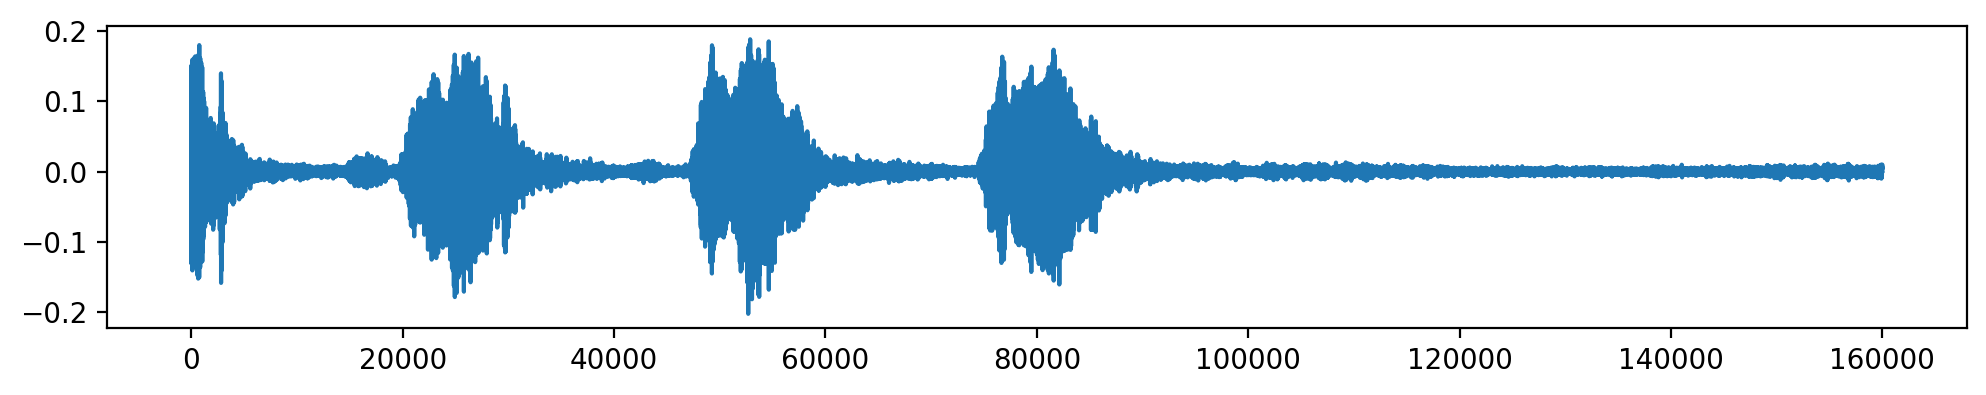

In [5]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12, 2), dpi=200)
plt.plot(audio_clip)

In [6]:
import IPython.display as ipd
ipd.display(ipd.Audio(data=audio_clip, rate=sr))

In [7]:
# make audio_clip a torch tensor
audio_clip = 1/2 * (audio_clip + 1)
audio_clip_tensor = torch.from_numpy(audio_clip)

# make it float and insert a fake batch dimension
# test_value = Variable(audio_clip_tensor.cuda()) if GPU available
test_value = audio_clip_tensor
test_value = test_value.float()
test_value = test_value.unsqueeze(0)

# pass it through the model
#     with torch.no_grad():
#         prediction = model(test_value)
#         prediction_results[k,:] = prediction['clipwise_output']
#         k += 1
#         bird_code = prediction['clipwise_output'].argmax()
        
# print feature map
prediction = model(test_value)
predicted_bird_codes = (-prediction['clipwise_output'].detach().numpy()[0]).argsort()[:3]
print("predicted_bird_codes:")
print(predicted_bird_codes)
print("Probabilities:")
print(prediction['clipwise_output'].detach().numpy()[0][predicted_bird_codes])
predicted_bird_names = [INV_BIRD_CODE[code] for code in predicted_bird_codes]
print("predicted_bird_names")
print(predicted_bird_names)

predicted_bird_codes:
[33 76  2]
Probabilities:
[0.99667704 0.02362855 0.00326637]
predicted_bird_names
['Corvus', 'Sonus', 'Garrulus']


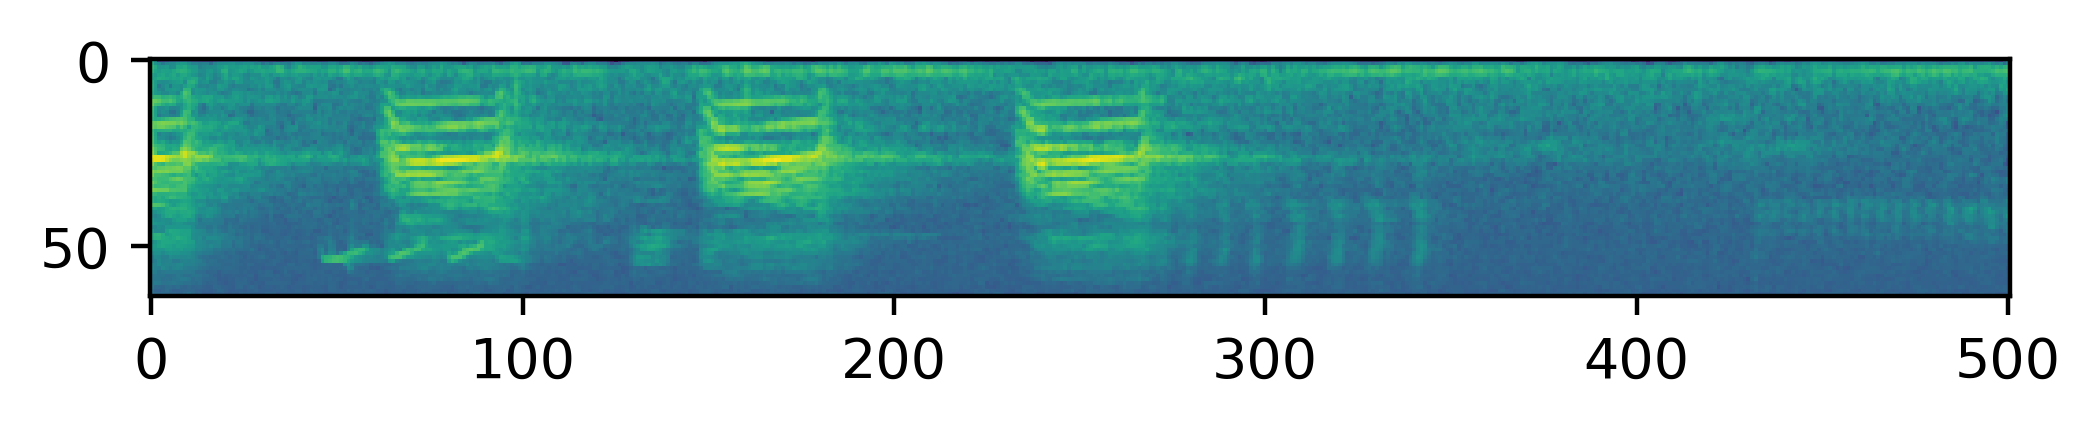

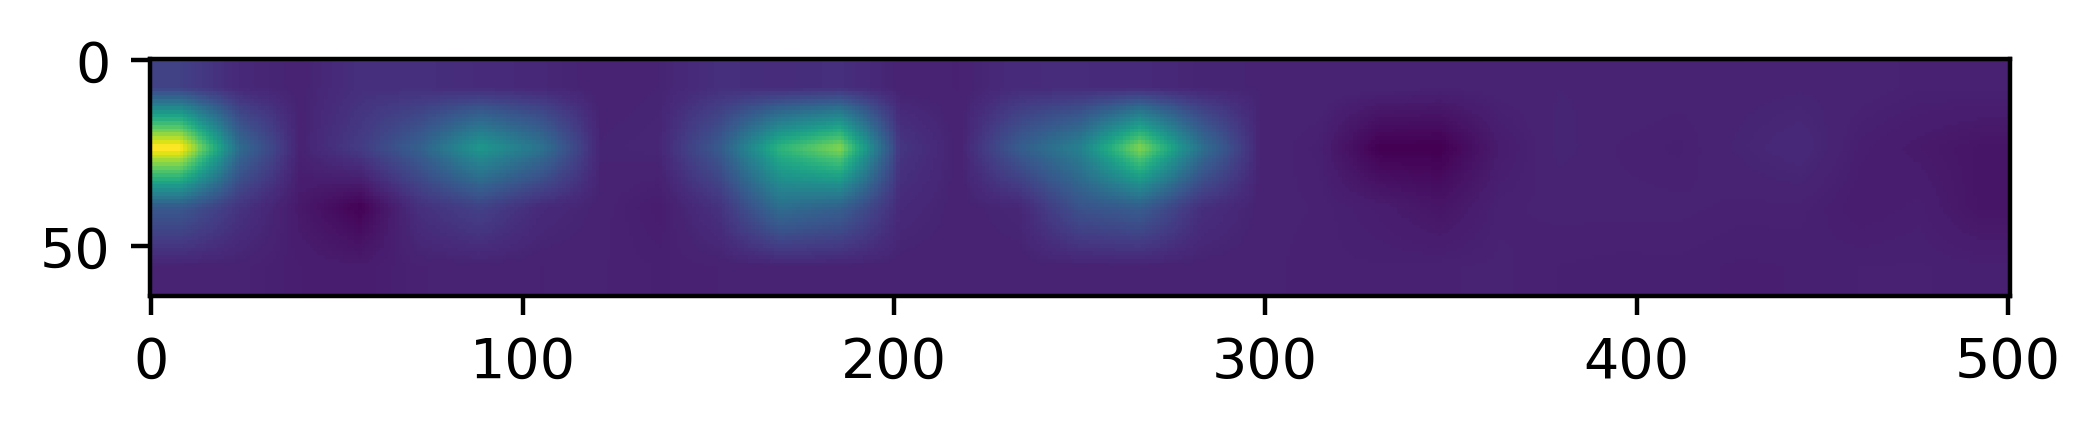

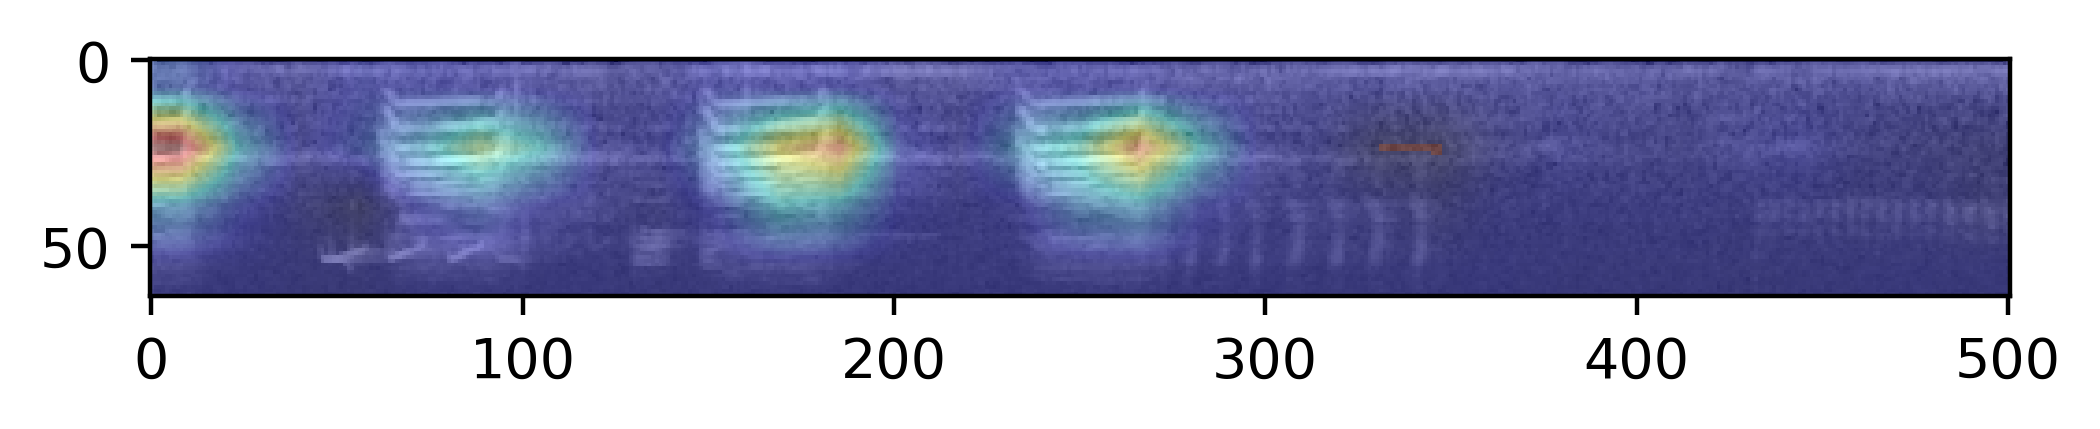

In [8]:
prediction_result = prediction['clipwise_output']
# Target for backprop
target_index = 33
one_hot_output = torch.FloatTensor(1, prediction_result.size()[-1]).zero_()
one_hot_output[0][target_index] = 1

# Backward pass with specified target
prediction_result.backward(gradient=one_hot_output, retain_graph=True)

spec_image = model.module.base.spectrogram.squeeze().T.numpy()
spec_image = (spec_image - np.min(spec_image)) / (np.max(spec_image) - np.min(spec_image)) 
spec_image = np.uint8(spec_image * 255)  # Scale between 0-255 to visualize
plt.figure(dpi=400)
plt.imshow(np.uint8(spec_image))

spec_image_3channel = np.zeros([64, 501, 3])
for k in np.arange(3):
    spec_image_3channel[:,:,k] = spec_image
    
# Get hooked gradients
guided_gradients = model.module.base.gradients.data.numpy()[0]
np.shape(guided_gradients)

# Get convolution outputs
target = model.module.base.conv_output.data.numpy()[0]

# Get weights from gradients
# Take averages for each gradient
weights = np.mean(guided_gradients, axis=(1, 2))
# Create empty numpy array for cam
cam = np.ones(target.shape[1:], dtype=np.float32)
# Multiply each weight with its conv output and then, sum
for i, w in enumerate(weights):
    cam += w * target[i, :, :]
cam = cv2.resize(cam, (64, 501))
cam = np.maximum(cam, 0)
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
plt.figure(dpi=400)
plt.imshow(cam.T)


heatmap = cv2.applyColorMap(np.uint8(255 * cam.T), cv2.COLORMAP_JET)

image_with_heatmap = 0.7 * spec_image_3channel + 0.3 * heatmap
plt.figure(dpi=400)
plt.imshow(np.uint8(image_with_heatmap))

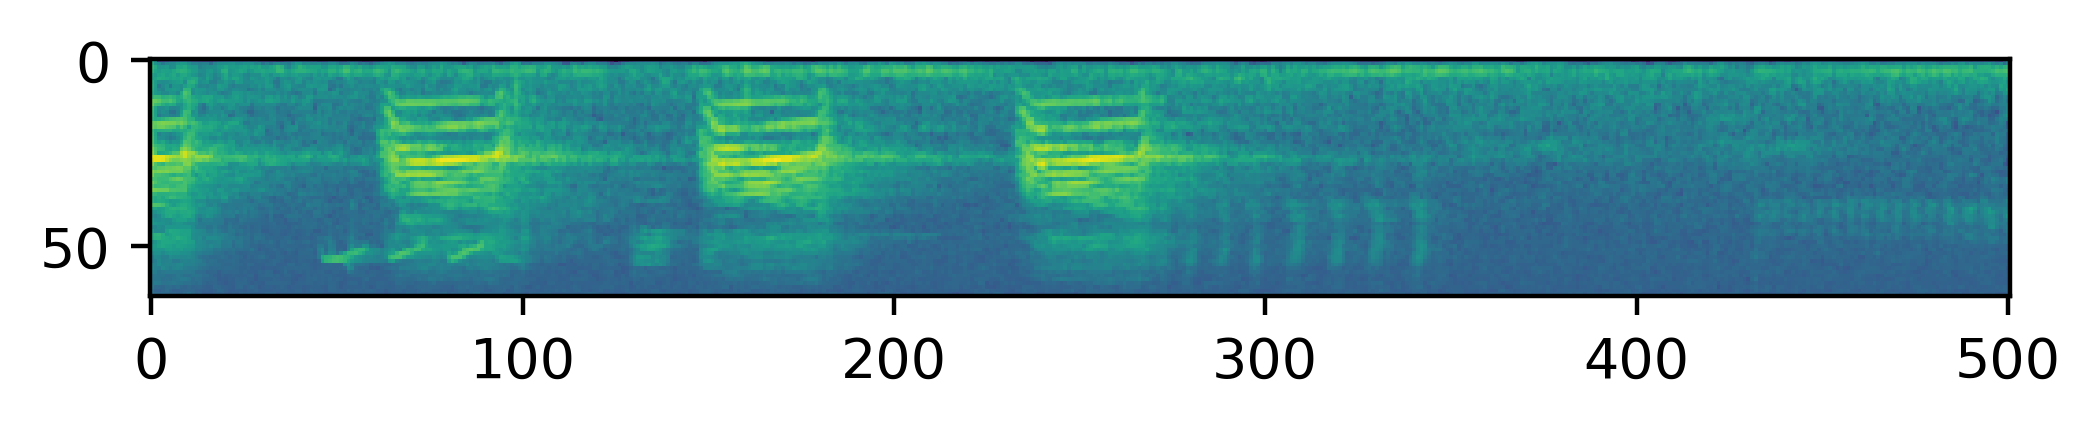

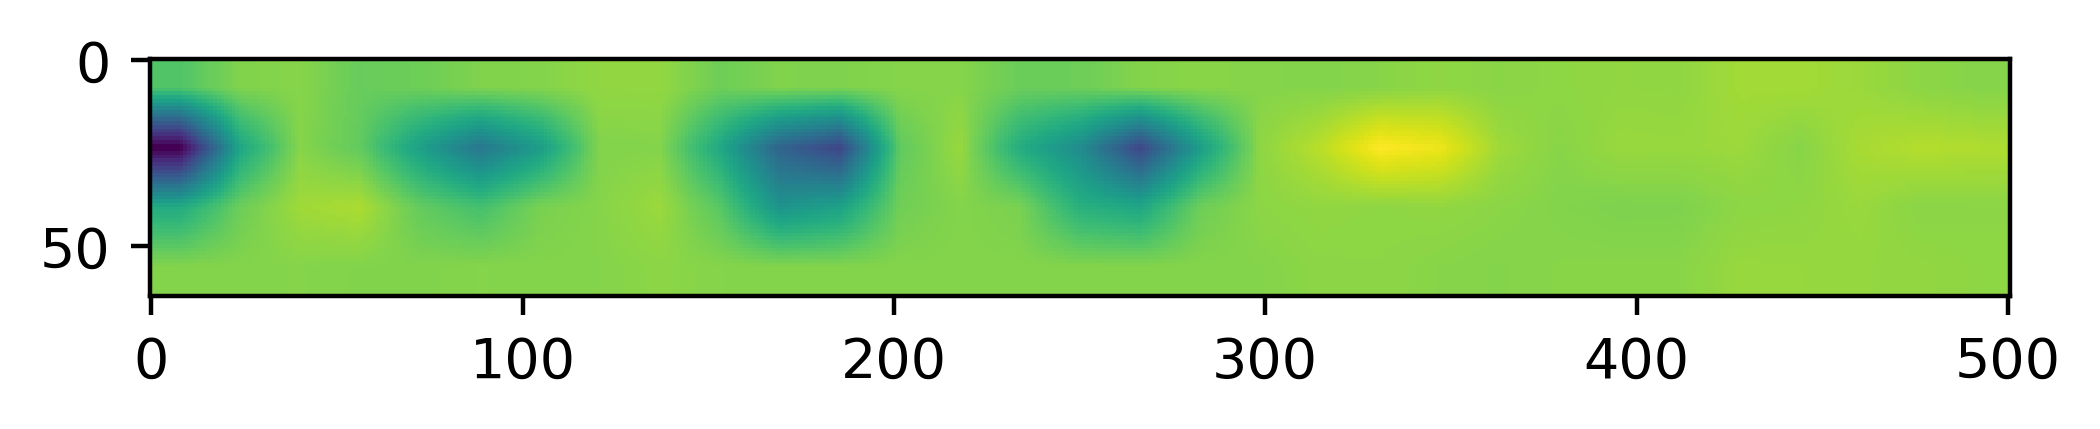

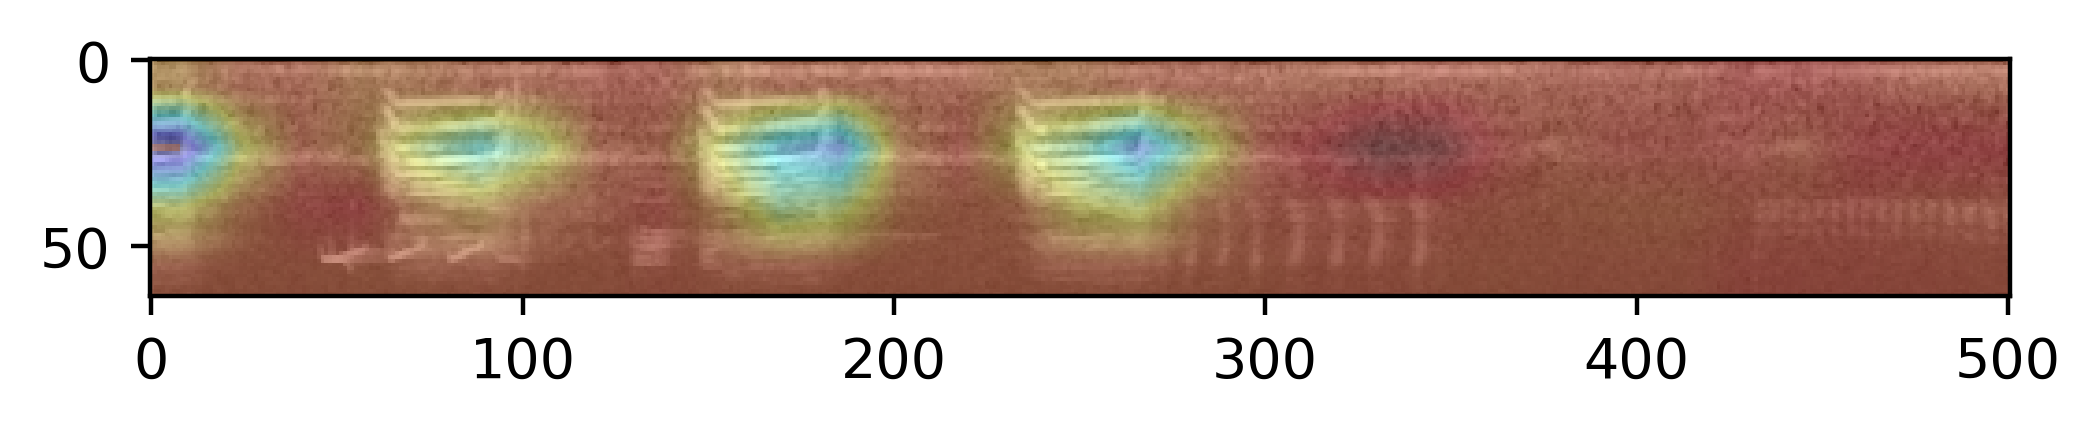

In [9]:
prediction_result = prediction['clipwise_output']
# Target for backprop
target_index = 76
one_hot_output = torch.FloatTensor(1, prediction_result.size()[-1]).zero_()
one_hot_output[0][target_index] = 1

# Backward pass with specified target
prediction_result.backward(gradient=one_hot_output, retain_graph=True)

spec_image = model.module.base.spectrogram.squeeze().T.numpy()
spec_image = (spec_image - np.min(spec_image)) / (np.max(spec_image) - np.min(spec_image)) 
spec_image = np.uint8(spec_image * 255)  # Scale between 0-255 to visualize
plt.figure(dpi=400)
plt.imshow(np.uint8(spec_image))

spec_image_3channel = np.zeros([64, 501, 3])
for k in np.arange(3):
    spec_image_3channel[:,:,k] = spec_image
    
# Get hooked gradients
guided_gradients = model.module.base.gradients.data.numpy()[0]
np.shape(guided_gradients)

# Get convolution outputs
target = model.module.base.conv_output.data.numpy()[0]

# Get weights from gradients
# Take averages for each gradient
weights = np.mean(guided_gradients, axis=(1, 2))
# Create empty numpy array for cam
cam = np.ones(target.shape[1:], dtype=np.float32)
# Multiply each weight with its conv output and then, sum
for i, w in enumerate(weights):
    cam += w * target[i, :, :]
cam = cv2.resize(cam, (64, 501))
cam = np.maximum(cam, 0)
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
plt.figure(dpi=400)
plt.imshow(cam.T)


heatmap = cv2.applyColorMap(np.uint8(255 * cam.T), cv2.COLORMAP_JET)

image_with_heatmap = 0.7 * spec_image_3channel + 0.3 * heatmap
plt.figure(dpi=400)
plt.imshow(np.uint8(image_with_heatmap))

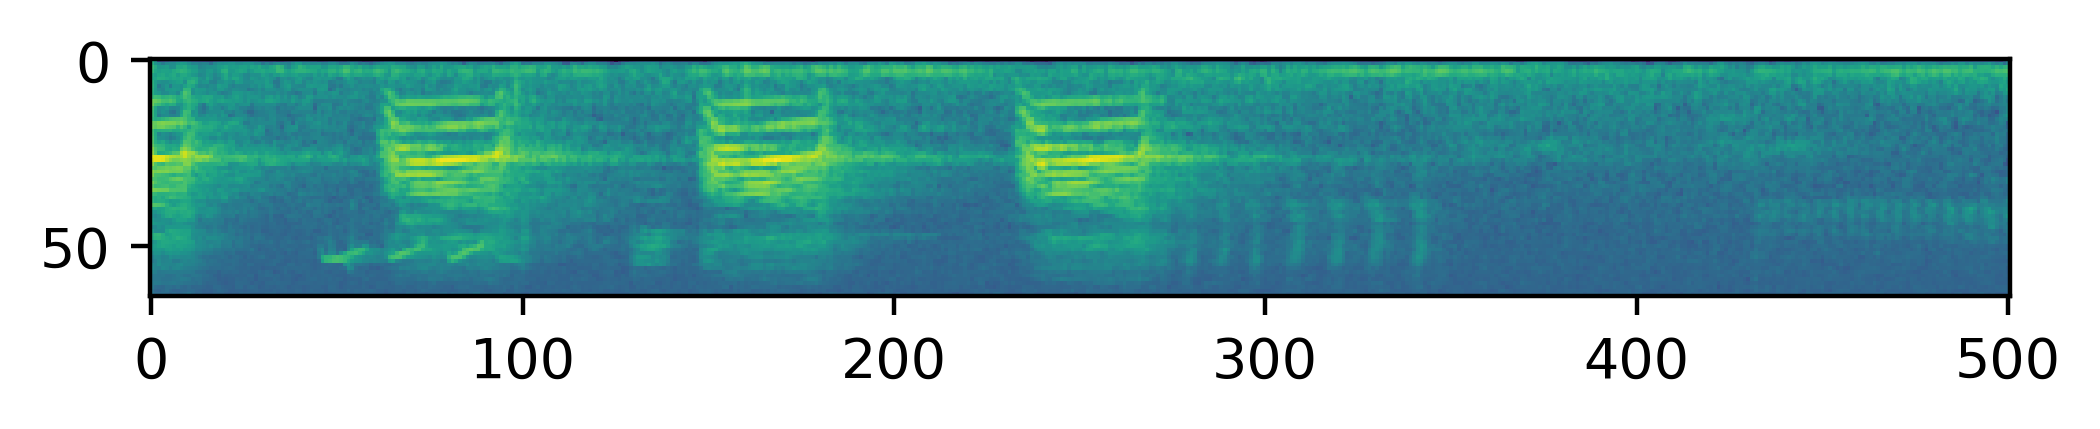

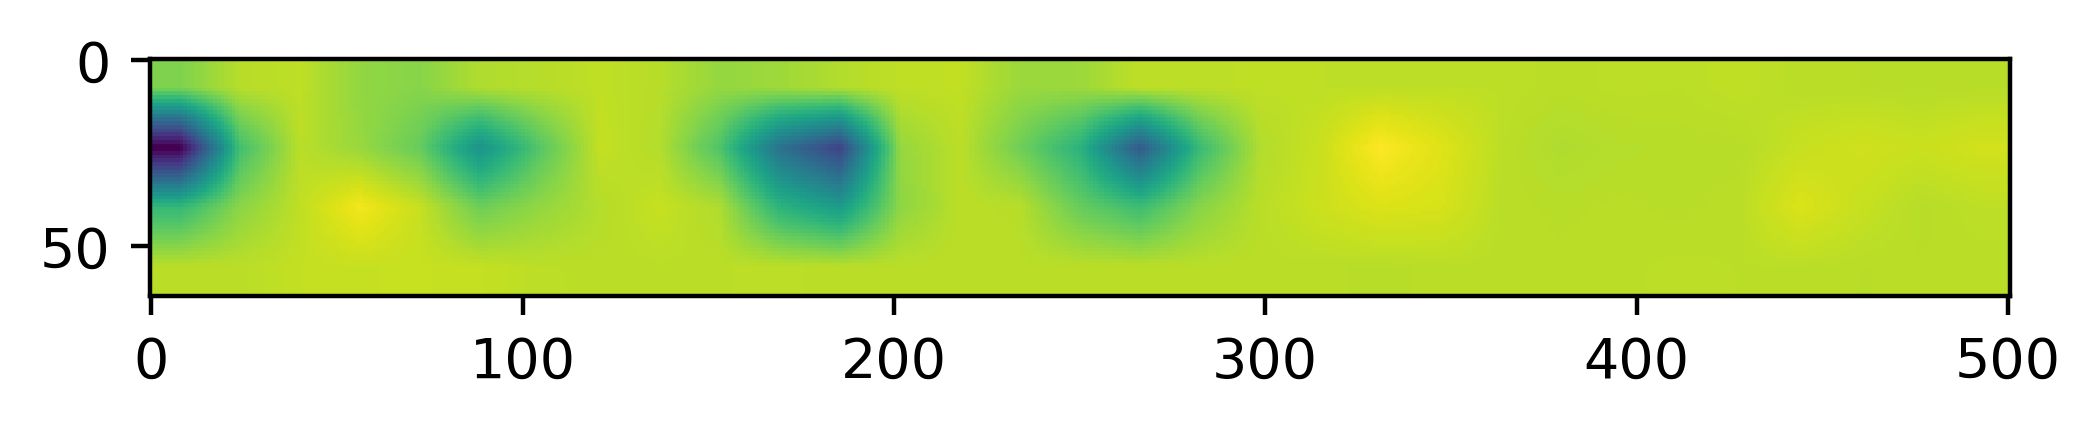

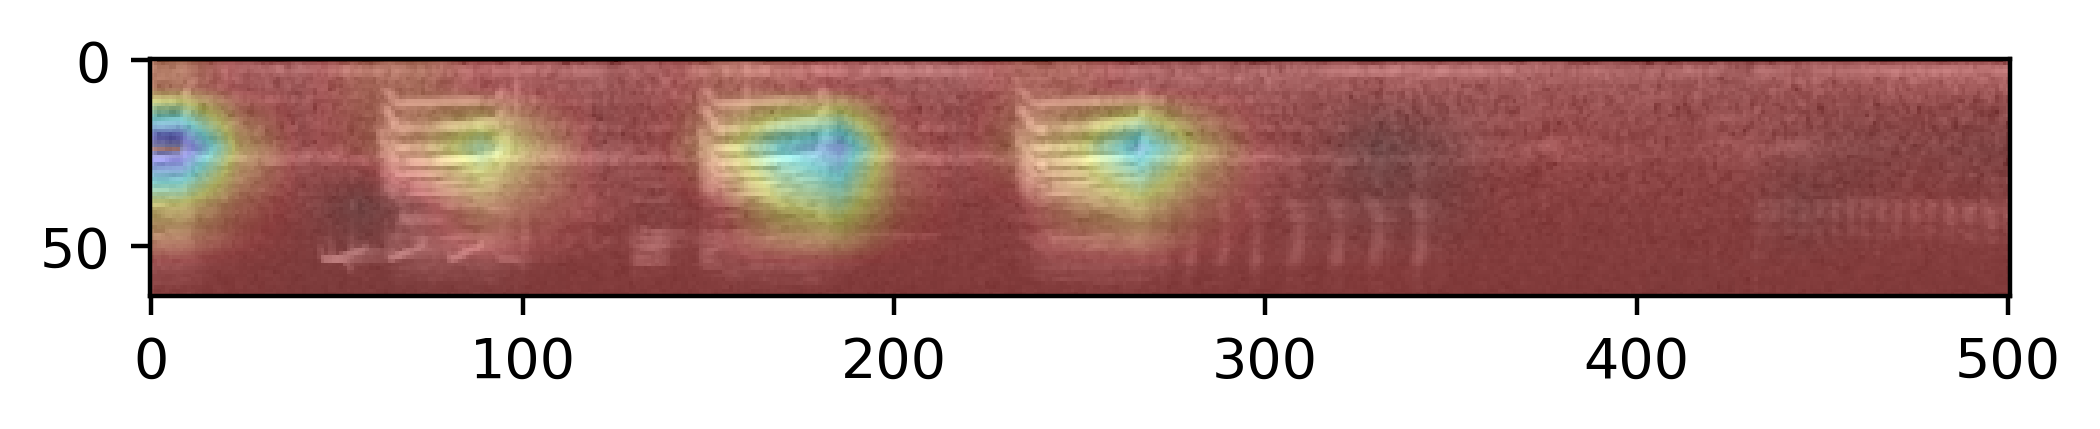

In [13]:
prediction_result = prediction['clipwise_output']
# Target for backprop
target_index = 2
one_hot_output = torch.FloatTensor(1, prediction_result.size()[-1]).zero_()
one_hot_output[0][target_index] = 1

# Backward pass with specified target
prediction_result.backward(gradient=one_hot_output, retain_graph=True)

spec_image = model.module.base.spectrogram.squeeze().T.numpy()
spec_image = (spec_image - np.min(spec_image)) / (np.max(spec_image) - np.min(spec_image)) 
spec_image = np.uint8(spec_image * 255)  # Scale between 0-255 to visualize
plt.figure(dpi=400)
plt.imshow(np.uint8(spec_image))

spec_image_3channel = np.zeros([64, 501, 3])
for k in np.arange(3):
    spec_image_3channel[:,:,k] = spec_image
    
# Get hooked gradients
guided_gradients = model.module.base.gradients.data.numpy()[0]
np.shape(guided_gradients)

# Get convolution outputs
target = model.module.base.conv_output.data.numpy()[0]

# Get weights from gradients
# Take averages for each gradient
weights = np.mean(guided_gradients, axis=(1, 2))
# Create empty numpy array for cam
cam = np.ones(target.shape[1:], dtype=np.float32)
# Multiply each weight with its conv output and then, sum
for i, w in enumerate(weights):
    cam += w * target[i, :, :]
cam = cv2.resize(cam, (64, 501))
cam = np.maximum(cam, 0)
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
plt.figure(dpi=400)
plt.imshow(cam.T)


heatmap = cv2.applyColorMap(np.uint8(255 * cam.T), cv2.COLORMAP_JET)

image_with_heatmap = 0.7 * spec_image_3channel + 0.3 * heatmap
plt.figure(dpi=400)
plt.imshow(np.uint8(image_with_heatmap))